### Car Brand Classification
##### Set train test validation

##### Import

In [1]:
all = [var for var in globals() if var[0] != "_"]   # globals() 목록의 첫글자가 _ 로 시작하지 않는 자료의 리스트만 가져와서
for var in all:
    del globals()[var]

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

##### Data load

In [3]:
PATH = 'd:/CarsDataset'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

In [4]:
# batchsize, image size 지정
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 3352 files belonging to 7 classes.
Found 813 files belonging to 7 classes.


In [5]:
class_names = train_dataset.class_names
class_names

['Audi',
 'Hyundai Creta',
 'Mahindra Scorpio',
 'Rolls Royce',
 'Swift',
 'Tata Safari',
 'Toyota Innova']

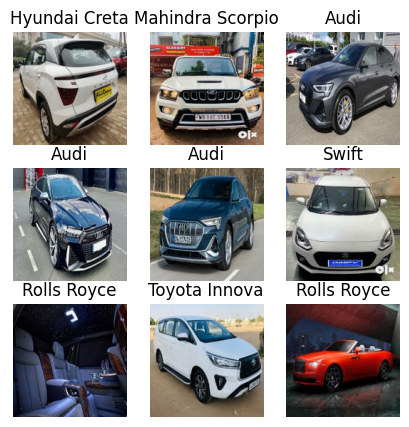

In [6]:
plt.figure(figsize=(5, 5))

for images, labels in train_dataset.take(1):
  for i in range(9):  # 9개의 이미지 출력
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))  # 이미지 표현을 위해 numpy 배열 dtype을 uint8로 지정
    plt.title(class_names[labels[i]])  # images에 해당하는 레이블 출력
    plt.axis("off") 

In [7]:
val_batches = tf.data.experimental.cardinality(validation_dataset)

test_dataset = validation_dataset.take(val_batches // 5)

validation_dataset = validation_dataset.skip(val_batches // 5)

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

##### Data augmentation

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomContrast(0.3)
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


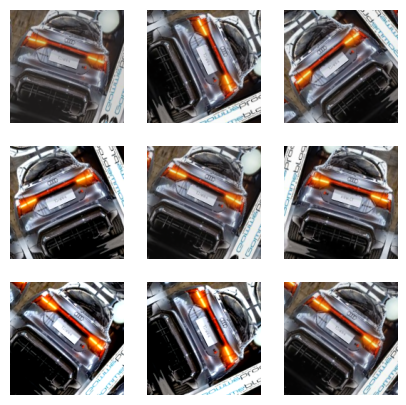

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(5,5))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    # tf.expand_dims를 통해 기존 이미지의 차원을 확장함 (first_image : 차원이 늘려질 배열, 0(axis) : 몇 번째 차원의 크기를 늘릴 것인지)
    # 차원 확장 후 이미지 증강 기법 적용
    # https://www.tensorflow.org/api_docs/python/tf/expand_dims
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### Transfer learning - ResNet50

##### Feature Extraction

In [39]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model_2 = tf.keras.applications.resnet50.ResNet50(input_shape=IMG_SHAPE,
                                                    include_top=False,
                                                    weights='imagenet')

In [40]:
base_model_2.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 166, 166, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 80, 80, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 80, 80, 64)   256         ['conv1_conv[0][0]']      

##### layer 출력물 확인

In [41]:
get_layer_name = [layer.name for layer in base_model_2.layers]
get_output = [layer.output for layer in base_model_2.layers]
# get_output

In [16]:
#################################### 한 레이어의 전체 featuremap 확인

# from PIL import Image

# visual_model = tf.keras.models.Model(inputs=base_model_2.input, outputs=get_output[3])
# # visual_model.summary()

# file='d:/CarsDataset/test_img/1.jpg'

# img=Image.open(file).resize((160,160))
# img=np.array(img)
# newimg=np.reshape(img, (1,160,160,3))
# feature_maps = visual_model.predict(newimg)

# feature_maps.shape
# # len(feature_maps[0][0][0])

# feature_n = len(feature_maps[0][0][0])
# ix = 1
# for i in range(feature_n):
#     for j in range(feature_n):
#         ax = plt.subplot(feature_n,feature_n,ix)
#         ax.set_xticks([])
#         ax.set_yticks([])
#         # Feature Map
#         # plt.imshow(feature_maps[0,:,:,ix-1])
#         plt.imshow(feature_maps[0][:,:,j],cmap='gray')
#         ix = ix + 1
# plt.show()

In [17]:
# from PIL import Image

# plt.figure(figsize=(2,2))

# # file='d:/1.jpg'
# file='d:/CarsDataset/test_img/1.jpg'

# visual_model = tf.keras.models.Model(inputs=base_model_2.input, outputs=get_output[100])
# visual_model.summary()

# img=Image.open(file).resize((160,160))
# img=np.array(img)
# newimg=np.reshape(img, (1,160,160,3))
# feature_maps = visual_model.predict(newimg)
# plt.imshow(img,cmap='gray')

# plt.figure(figsize=(20,4))
# cnt=1
# for x in range(10):
#     plt.subplot(1,10,cnt)
#     plt.imshow(feature_maps[0][:,:,x],cmap='gray')
#     cnt+=1

# feature_maps[0][0][0]

In [42]:
for i, j in enumerate(base_model_2.layers):
    print(i, j.name)

0 input_3
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

<Figure size 200x200 with 0 Axes>

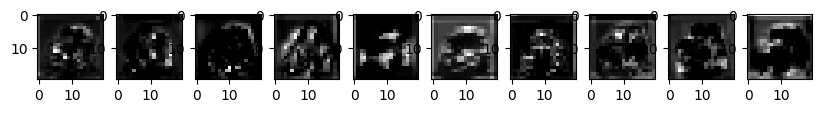

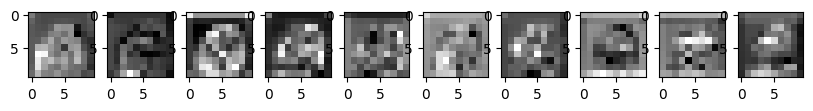

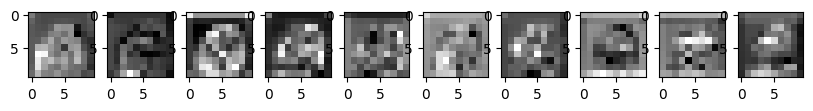

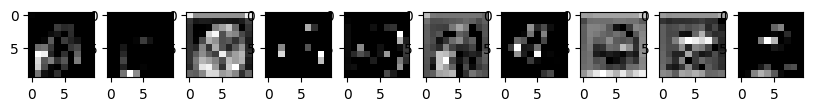

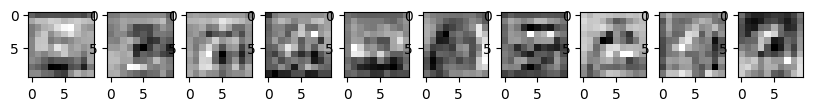

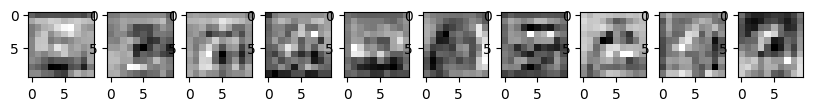

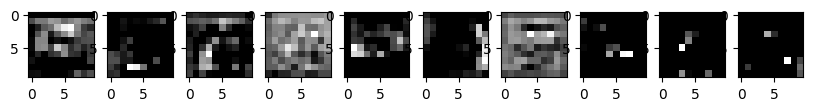

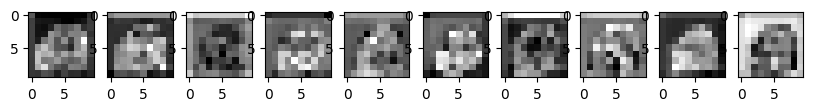

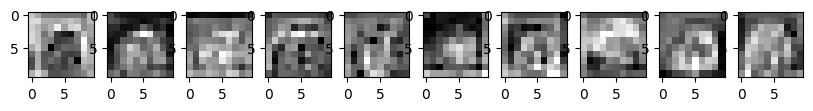

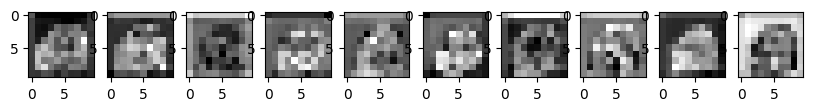

In [23]:
from PIL import Image

plt.figure(figsize=(2,2))

# file='d:/1.jpg'
file='d:/CarsDataset/test_img/1.jpg'

img=Image.open(file).resize((160,160))
img=np.array(img)
newimg=np.reshape(img, (1,160,160,3))
   
def check_feature(num_layer, input_img):
  ins = base_model_2.input
  outs = base_model_2.layers[num_layer].output

  feature_map = tf.keras.models.Model(ins, outs)

  feature = feature_map.predict(input_img)
#   print(feature.shape)

  plt.figure(figsize=(10,4))
  for i in range(10):
    plt.subplot(1,10, i+1)
    plt.imshow(feature[0,:,:,i], cmap="gray")

  plt.show()

for i in range(80, 90):
  check_feature(i, newimg)

In [43]:
preprocess_input_2 = tf.keras.applications.resnet50.preprocess_input

In [44]:
base_model_2.trainable = False

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

prediction_layer = tf.keras.layers.Dense(7, activation='softmax')

In [45]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)  # 데이터 증강
x = preprocess_input_2(x) # 전처리
x = base_model_2(x, training=False) # MobileNet V2d의 basemodel
# x = tf.keras.layers.Dropout(0.2)(x)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)  # output layer
model_2 = tf.keras.Model(inputs, outputs)

In [46]:
model_2.summary()

Model: "model_73"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 160, 160, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0  

##### Compile Model

In [47]:
base_learning_rate = 0.0001  # 학습률 지정
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
initial_epochs = 10
# 12

#러닝레이트의 비율을 유동적으로 변화할 수 있도록 설정함
def scheduler(epoch, learning_rate):
    if epoch < 5:
        return learning_rate
    else:
        return learning_rate * tf.math.exp(-0.1)
lr_scheduler_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

history_2 = model_2.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[lr_scheduler_cb])

Epoch 1/10


105/105 [==============================] - 8s 62ms/step - loss: 2.2977 - accuracy: 0.2088 - val_loss: 1.7484 - val_accuracy: 0.3675 - lr: 1.0000e-04
Epoch 2/10
105/105 [==============================] - 6s 60ms/step - loss: 1.8912 - accuracy: 0.3356 - val_loss: 1.5253 - val_accuracy: 0.4747 - lr: 1.0000e-04
Epoch 3/10
105/105 [==============================] - 6s 60ms/step - loss: 1.6844 - accuracy: 0.3974 - val_loss: 1.3355 - val_accuracy: 0.5789 - lr: 1.0000e-04
Epoch 4/10
105/105 [==============================] - 6s 60ms/step - loss: 1.5528 - accuracy: 0.4481 - val_loss: 1.2310 - val_accuracy: 0.5911 - lr: 1.0000e-04
Epoch 5/10
105/105 [==============================] - 6s 60ms/step - loss: 1.4897 - accuracy: 0.4711 - val_loss: 1.1503 - val_accuracy: 0.6217 - lr: 1.0000e-04
Epoch 6/10
105/105 [==============================] - 6s 58ms/step - loss: 1.4227 - accuracy: 0.5012 - val_loss: 1.0620 - val_accuracy: 0.6616 - lr: 9.0484e-05
Epoch 7/10
105/105 [==============================]

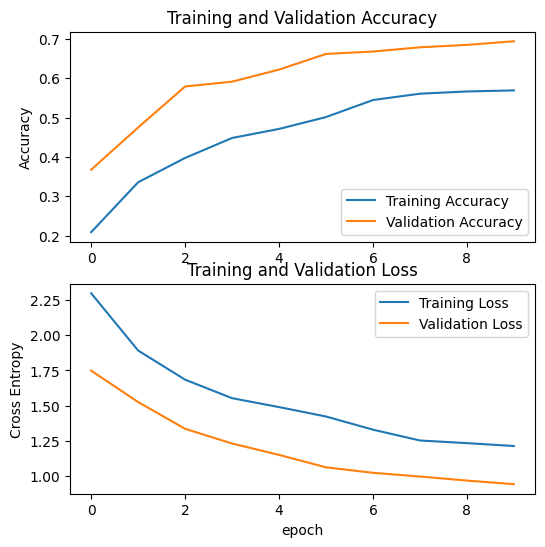

In [49]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Fine Tuning

In [50]:
base_model_2.trainable = True

print(len(base_model_2.layers))

for i, j in enumerate(base_model_2.layers):
    print(i, j.name)

175
0 input_3
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_

In [51]:
fine_tune_at = 80
#123
for layer in base_model_2.layers[:fine_tune_at]:
  layer.trainable = False

In [52]:
model_2.compile(loss='sparse_categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [53]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine_2 = model_2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history_2.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20


105/105 [==============================] - 15s 113ms/step - loss: 1.0378 - accuracy: 0.6375 - val_loss: 0.6120 - val_accuracy: 0.8025
Epoch 11/20
105/105 [==============================] - 11s 106ms/step - loss: 0.7726 - accuracy: 0.7309 - val_loss: 0.4779 - val_accuracy: 0.8423
Epoch 12/20
105/105 [==============================] - 11s 106ms/step - loss: 0.6042 - accuracy: 0.7965 - val_loss: 0.3670 - val_accuracy: 0.8775
Epoch 13/20
105/105 [==============================] - 11s 107ms/step - loss: 0.4948 - accuracy: 0.8380 - val_loss: 0.3278 - val_accuracy: 0.8882
Epoch 14/20
105/105 [==============================] - 11s 107ms/step - loss: 0.4338 - accuracy: 0.8622 - val_loss: 0.3330 - val_accuracy: 0.8897
Epoch 15/20
105/105 [==============================] - 11s 107ms/step - loss: 0.3314 - accuracy: 0.8869 - val_loss: 0.2910 - val_accuracy: 0.9005
Epoch 16/20
105/105 [==============================] - 11s 107ms/step - loss: 0.2880 - accuracy: 0.9013 - val_loss: 0.2734 - val_accurac

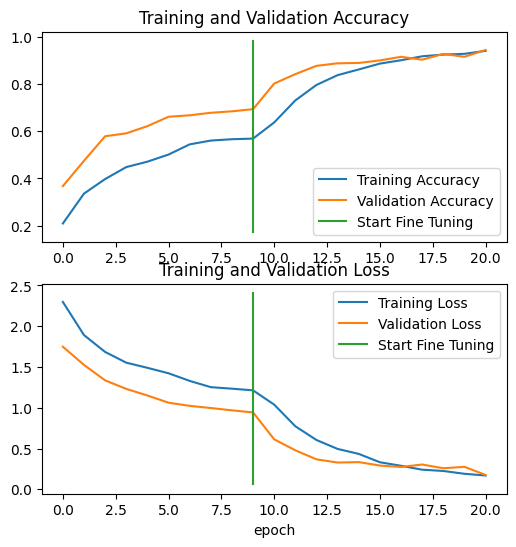

In [54]:
acc += history_fine_2.history['accuracy']
val_acc += history_fine_2.history['val_accuracy']

loss += history_fine_2.history['loss']
val_loss += history_fine_2.history['val_loss']

plt.figure(figsize=(6, 6))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

##### Predict & Evaluation

In [55]:
loss, accuracy = model_2.evaluate(test_dataset)
print('Test accuracy :', accuracy)

5/5 [==============================] - 0s 38ms/step - loss: 0.1976 - accuracy: 0.9375
Test accuracy : 0.9375


[5 6 5 0 4 0 2 6 2] [5 6 5 0 4 0 2 6 2]


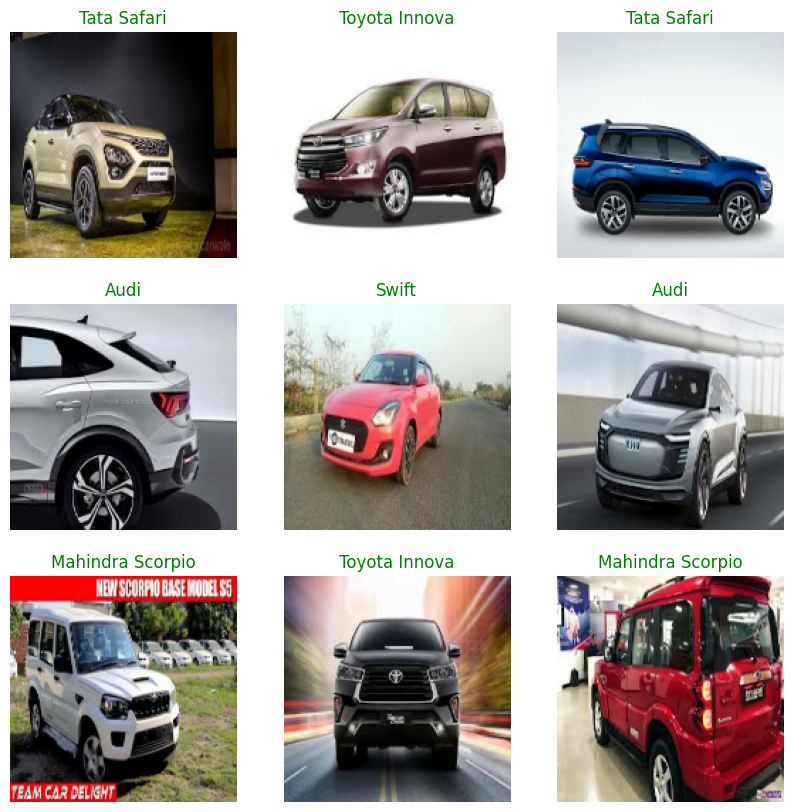

In [57]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model_2.predict_on_batch(image_batch)
# print(predictions)
predBun=np.argmax(predictions, axis=-1)
# print(predBun)

print(predBun[:9], label_batch[:9])

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  color = "green" if predBun[i] == label_batch[i] else "red"
  # print(class_names[predBun[i]],label_batch[i], color)
  plt.title(class_names[predBun[i]], color=color)
  plt.axis("off")


##### Test_image 적용

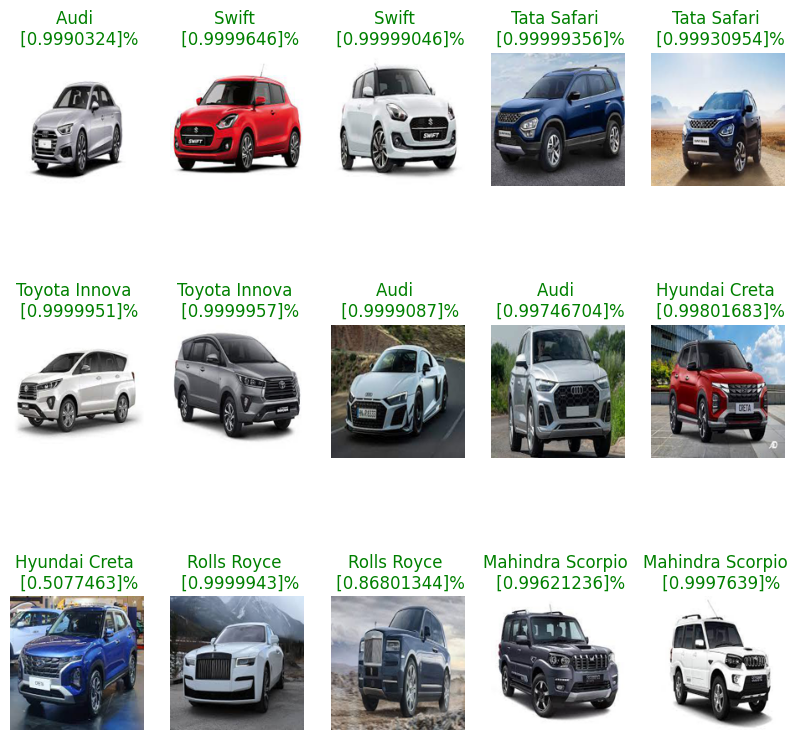

In [58]:
from PIL import Image
from glob import glob

test_dir = 'd:/CarsDataset/test_img/*'
test_files=glob(test_dir)

real_test_labes = [0,4,4,5,5,6,6,0,0,1,1,3,3,2,2]   # 실제 testset 라벨 값

plt.figure(figsize=(10,10))

for n, file in enumerate(test_files):
    ax=plt.subplot(3,5,n+1)
    img=Image.open(file).resize((160,160)).convert('RGB')
    img=np.array(img)
    newimg=np.reshape(img, (1,160,160,3))
    pred=model_2.predict(newimg)
    predBun=np.argmax(pred)
    # print(class_names[predBun], pred[:,predBun])
    plt.title(f'{class_names[predBun]}: {pred[:,predBun]}%')
    # plt.figure(figsize=(3,3))
    plt.imshow(img)
    color = "green" if predBun == real_test_labes[n] else "red"
    plt.title(f'{class_names[predBun]} \n {pred[:,predBun]}%', color=color)
    # plt.show()
    plt.axis("off")


In [148]:
# export_path = "saved_models_ResNet50/{}".format(int(t))
# model_2.save(export_path, save_format='tf')

# export_path

In [149]:
# from keras.models import load_model

# model_2.save('ResNet50_model.h5')